## Testing the LESS Denoising Code 

In [1]:
%matplotlib widget

import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import cv2
from skimage.draw import polygon2mask
from skimage.measure import find_contours
import subprocess
import sys
import tifffile

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display
import torch
import sys
import os
less_path = os.path.abspath(os.path.join("..", "LESS_ver_alpha"))
if less_path not in sys.path:
    sys.path.insert(0, less_path)
from less import denoise
from utils import set_seed
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

ModuleNotFoundError: No module named 'cv2'

In [7]:
def movie_path(mouse, date, file):
    return "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF.h5'

path_movie = movie_path("cmm002mjr", 231213, 'meas03')

with h5py.File(path_movie, 'r') as mov_file:
    specs = mov_file["specs"]
    mov = mov_file['mov'][()][:2000]
    fps = specs['fps'][()][0][0][0]
    raw_mask = specs["extra_specs"]["mask"][()][0]
    binning = specs["binning"][()][0][0][0]  # Extract binning factor

def mask_movie(movie, raw_mask, binning):
    # Resize the mask using bilinear interpolation
    mask = cv2.resize(raw_mask, (0, 0), fx=1/binning, fy=1/binning, interpolation=cv2.INTER_LINEAR)
    # Ensure mask has the same shape as the movie
    movie_size = movie.shape[1:3]  # Get spatial dimensions of the movie
    mask = mask[:movie_size[0], :movie_size[1]]  # Crop mask to match movie size
    mask = mask.astype(bool)         # Convert to boolean mask
    return movie * mask  # Apply mask

movie = np.nan_to_num(mov)
movie_masked = mask_movie(movie, raw_mask, binning)

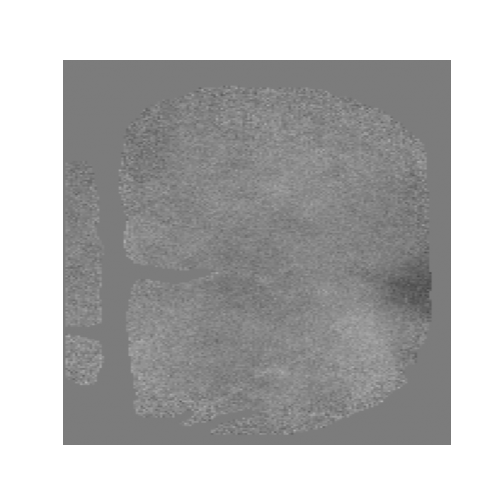

In [3]:
def show_movie(frames, fps=50):
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], cmap='gray', vmin=frames.min(), vmax=frames.max(), aspect='auto')
    ax.axis("off")
    fig.set_size_inches(5, 5)  # Adjust for your aspect ratio

    def update(i):
        im.set_array(frames[i])
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000/fps, blit=True)

    return ani

ani = show_movie(movie_masked)

In [ ]:
movie_tensor = torch.from_numpy(movie_masked).float()

denoised_tensor = denoise(
    data=movie_tensor,
    cuda=False,               # Force CPU
    patch_size=patch_size,
    top_k=top_k,
    window_size=window_size,
    stride=stride,
    pat=pat,
    verbose=verbose
)

denoised = denoised_tensor.numpy()